In [1]:
import numpy as np
import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt



In [2]:

class QuadrotorEnv(gym.Env):
    metadata = {'render.modes': ['console']}

    def __init__(self):
        super(QuadrotorEnv, self).__init__()

        # Constants
        self.g = 9.81  # gravity
        self.m = 1.0   # mass of the UAV
        self.mu = 0.05 # damping factor
        self.dt = 0.02 # time step

        # Define action and observation space
        # Actions are thrust T, angle phi, angle theta
        self.action_space = spaces.Box(low=np.array([0, -np.pi, -np.pi]), 
                                       high=np.array([20, np.pi, np.pi]), dtype=np.float32)

        # Observation space: x, y, z, vx, vy, vz
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)

        # State initialization
        self.state = None
        self.reset()

    def step(self, action):
        T, phi, theta = action
        x, y, z, vx, vy, vz = self.state

        # Calculate accelerations
        ax = (-0.7071 * np.cos(phi) * np.sin(theta) - 0.7071 * np.sin(phi)) * T / self.m
        ay = (-0.7071 * np.cos(phi) * np.sin(theta) - 0.7071 * np.sin(phi)) * T / self.m
        az = self.g - (np.cos(phi) * np.cos(theta)) * T / self.m

        # Update velocities
        vx += (ax - self.mu * vx) * self.dt
        vy += (ay - self.mu * vy) * self.dt
        vz += (az - self.mu * vz) * self.dt

        # Update positions
        x += vx * self.dt
        y += vy * self.dt
        z += vz * self.dt

        # Update state
        self.state = np.array([x, y, z, vx, vy, vz])

        # Calculate reward (placeholder)
        # reward = -np.sqrt((x - 5 * np.cos(1.2 * self.current_step * self.dt))**2 + (y - 5 * np.sin(1.2 * self.current_step * self.dt))**2 + (z + 20)**2)
        reward=0.5* -np.sqrt((x - 5 * np.cos(1.2 * self.current_step * self.dt))**2 + (y - 5 * np.sin(1.2 * self.current_step * self.dt))**2 + (z + 20)**2)+0.3 * np.sqrt((vx+6 * np.sin(1.2 * self.current_step * self.dt))**2 + (vy-6*np.cos(1.2 * self.current_step * self.dt))**2 + vz**2)
    

        # Check if UAV is within the reasonable bounds (this is a simple check)
        done = z < -25 or self.current_step > 1000

        self.current_step += 1

        # Optionally we could add more info
        info = {}

        return self.state, reward, done, info

    def reset(self):
        # Reset the state
        self.state = np.array([0.0, 0.0, 0.0, 1.0, -1.0, 0.0], dtype=np.float32)
        self.current_step = 0
        return self.state

    def render(self, mode='console'):
        if mode == 'console':
            print(f'State: {self.state}')


In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        mean = self.fc(state)
        std = torch.exp(self.log_std).expand_as(mean)
        cov_matrix = torch.diag_embed(std)  # Create a diagonal covariance matrix
        return MultivariateNormal(mean, covariance_matrix=cov_matrix)


class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.fc(state)


In [4]:
# Assume state_dim and action_dim are defined based on your environment
state_dim = 6  # Example state dimension
action_dim = 3  # Example action dimension (T, theta, phi)

policy_net = PolicyNetwork(state_dim, action_dim)
value_net = ValueNetwork(state_dim)

policy_optimizer = optim.Adam(policy_net.parameters(), lr=0.002)
value_optimizer = optim.Adam(value_net.parameters(), lr=0.002)


In [5]:


def collect_data(env, policy_net, steps_per_epoch):
    state = env.reset()
    states, actions, rewards, log_probs, next_states, dones = [], [], [], [], [], []
    
    for _ in range(steps_per_epoch):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Prepare state tensor
        with torch.no_grad():
            distribution = policy_net(state_tensor)
            action = distribution.sample()
            log_prob = distribution.log_prob(action)
            action = action.squeeze(0).numpy()  # Squeeze and convert to numpy array

        next_state, reward, done, _ = env.step(action)  # Pass the correctly shaped action

        states.append(state_tensor)
        actions.append(torch.tensor(action))  # Store action as a tensor for later computation
        rewards.append(reward)
        log_probs.append(log_prob)
        next_states.append(torch.tensor(next_state, dtype=torch.float32))
        dones.append(done)

        state = next_state
        if done:
            state = env.reset()
    
    return states, actions, rewards, log_probs, next_states, dones


In [6]:
def calculate_returns(rewards, dones, gamma=0.4):
    """
    Calculate discounted returns for each time step.
    """
    returns = []
    R = 0  # The return at the final timestep is assumed to be zero
    for reward, done in reversed(list(zip(rewards, dones))):
        # Reset the return to zero upon starting a new episode
        if done:
            R = 0
        R = reward + gamma * R
        returns.insert(0, R)  # Insert the return at the beginning of the list
    return returns


In [7]:
def calculate_advantages(returns, states, value_net):
    """
    Calculate advantages as the difference between returns and current value estimates.
    """
    values = value_net(torch.stack(states)).detach().squeeze()
    advantages = [G - value for G, value in zip(returns, values)]
    return advantages


In [8]:

# Assuming your custom environment and the network classes are defined and imported
env = QuadrotorEnv()  # Replace with your actual environment instantiation

# Initialize policy and value networks
policy_net = PolicyNetwork(state_dim=6, action_dim=3)  # Adjust dimensions as per your setup
value_net = ValueNetwork(state_dim=6)

# Collect data
# states, actions, rewards, log_probs, next_states, dones = collect_data(env, policy_net, 1000)
collected_data = collect_data(env, policy_net, 1000)

# returns = calculate_returns(rewards, dones)
# advantages = calculate_advantages(returns, states, value_net)

# Here you can proceed to train your model using the collected data and calculated metrics


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [9]:
def ppo_update(policy_net, value_net, policy_optimizer, value_optimizer, states, actions, log_probs_old, returns, advantages, clip_param=0.2, epochs=10, batch_size=64):
    criterion = torch.nn.MSELoss()

    # Prepare tensors
    states = torch.stack(states)
    actions = torch.stack(actions)
    log_probs_old = torch.stack(log_probs_old)
    returns = torch.tensor(returns, dtype=torch.float32)
    advantages = torch.tensor(advantages, dtype=torch.float32)

    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    dataset = torch.utils.data.TensorDataset(states, actions, log_probs_old, returns, advantages)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for _ in range(epochs):
        for state, action, log_prob_old, return_, advantage in loader:
            # Update the policy network
            distribution = policy_net(state)
            log_prob = distribution.log_prob(action).sum(axis=1)
            ratio = torch.exp(log_prob - log_prob_old)
            
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - clip_param, 1 + clip_param) * advantage
            policy_loss = -torch.min(surr1, surr2).mean()

            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # Update the value network
            value_pred = value_net(state).squeeze()
            value_loss = criterion(value_pred, return_)
            
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()


In [10]:
# Example settings
steps_per_epoch = 4000
epochs = 50  # Total number of epochs to train

for epoch in range(epochs):
    states, actions, rewards, log_probs, next_states, dones = collect_data(env, policy_net, steps_per_epoch)
    returns = calculate_returns(rewards, dones)
    advantages = calculate_advantages(returns, states, value_net)
    
    ppo_update(policy_net, value_net, policy_optimizer, value_optimizer, states, actions, log_probs, returns, advantages)
    
    print(f'Epoch {epoch + 1}/{epochs} completed.')


Epoch 1/50 completed.
Epoch 2/50 completed.
Epoch 3/50 completed.
Epoch 4/50 completed.
Epoch 5/50 completed.
Epoch 6/50 completed.
Epoch 7/50 completed.
Epoch 8/50 completed.
Epoch 9/50 completed.
Epoch 10/50 completed.
Epoch 11/50 completed.
Epoch 12/50 completed.
Epoch 13/50 completed.
Epoch 14/50 completed.
Epoch 15/50 completed.
Epoch 16/50 completed.
Epoch 17/50 completed.
Epoch 18/50 completed.
Epoch 19/50 completed.
Epoch 20/50 completed.
Epoch 21/50 completed.
Epoch 22/50 completed.
Epoch 23/50 completed.
Epoch 24/50 completed.
Epoch 25/50 completed.
Epoch 26/50 completed.
Epoch 27/50 completed.
Epoch 28/50 completed.
Epoch 29/50 completed.
Epoch 30/50 completed.
Epoch 31/50 completed.
Epoch 32/50 completed.
Epoch 33/50 completed.
Epoch 34/50 completed.
Epoch 35/50 completed.
Epoch 36/50 completed.
Epoch 37/50 completed.
Epoch 38/50 completed.
Epoch 39/50 completed.
Epoch 40/50 completed.
Epoch 41/50 completed.
Epoch 42/50 completed.
Epoch 43/50 completed.
Epoch 44/50 complete

Episode 1: Reward = -253890.42826373794
Episode 2: Reward = -253382.9187371362
Episode 3: Reward = -252906.62963739692
Episode 4: Reward = -253919.48631372693
Episode 5: Reward = -253826.29932760727
Episode 6: Reward = -253861.30368930887
Episode 7: Reward = -253585.1069485067
Episode 8: Reward = -253330.96162077953
Episode 9: Reward = -254659.211728945
Episode 10: Reward = -252880.37803062625
Episode 11: Reward = -254019.30298215896
Episode 12: Reward = -254094.12623129433
Episode 13: Reward = -254132.76194217918
Episode 14: Reward = -253385.1256191397
Episode 15: Reward = -253275.9375804614
Episode 16: Reward = -253789.99453187612
Episode 17: Reward = -254687.78232462207
Episode 18: Reward = -253095.35867226965
Episode 19: Reward = -253640.60817371504
Episode 20: Reward = -253037.7012352189
Episode 21: Reward = -253840.8261687542
Episode 22: Reward = -252808.32841554357
Episode 23: Reward = -254334.32183127984
Episode 24: Reward = -254408.25489881737
Episode 25: Reward = -252588.0730

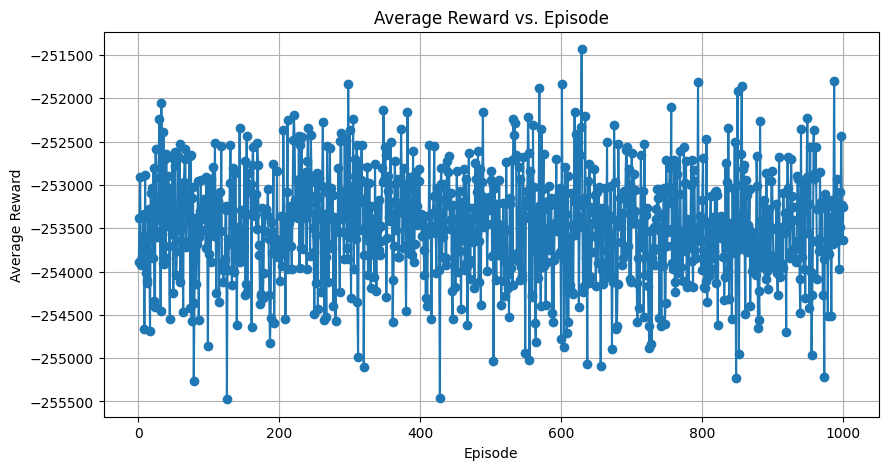

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def evaluate_model_and_plot(env, policy_net, num_episodes=1000):
    total_rewards = []
    for ep in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                distribution = policy_net(state_tensor)
                action = distribution.sample()
            # Ensure action is properly formatted as a numpy array without extra dimensions
            action = action.squeeze().numpy()  # Use .squeeze() to remove any singleton dimensions
            state, reward, done, _ = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
        print(f'Episode {ep+1}: Reward = {total_reward}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_episodes+1), total_rewards, marker='o', linestyle='-')
    plt.title('Average Reward vs. Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.show()

    return total_rewards

# Example usage
rewards_history = evaluate_model_and_plot(env, policy_net)
